# Single Link Redundancy Tutorial

## 🚗 What happens if one road is blocked?

In this tutorial, you will learn how to run a **single link redundancy analysis** with RA2CE. This type of analysis checks what happens if *one road segment* (also called a *link*) becomes unavailable:

- Is there another way to get around?
- How much longer is the detour compared to the original route?
- Which roads have **no backup options at all**?

> **Note**: This example does **not** require hazard maps, but you do need a prepared network. If you are new to networks in RA2CE, first go through the `network` tutorial.

![Basic principle of the single link redundancy analysis](/_resources/criticality_schema.png)

The redundancy of each link is expressed in the total distance (weighing) for the alternative route (weighing = distance). Below is a complete Python example demonstrating how to run a single link redundancy analysis with RA2CE.

## Step 1: Import Libraries and Set Paths

We start by importing the required libraries and defining the root directory and network path.

In [ ]:
from pathlib import Path
import geopandas as gpd

from ra2ce.analysis.analysis_config_data import SingleLinkRedundancyConfigData
from ra2ce.analysis.analysis_config_data.analysis_config_data import AnalysisConfigData
from ra2ce.analysis.analysis_config_data.enums.weighing_enum import WeighingEnum
from ra2ce.network.network_config_data.network_config_data import NetworkSection, NetworkConfigData
from ra2ce.network.network_config_data.enums.source_enum import SourceEnum
from ra2ce.ra2ce_handler import Ra2ceHandler

root_dir = Path('data', 'single_link_redundancy')
network_path = root_dir / "network"


c:\Users\hauth\miniforge3\envs\ra2ce_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Step 2: Define Network and Analysis Configuration

In [3]:
# Define the network section
network_section = NetworkSection(
    source=SourceEnum.SHAPEFILE,
    primary_file=network_path.joinpath("base_shapefile.shp"),
    save_gpkg=True
)

# Build the full configuration
network_config_data = NetworkConfigData(
    root_path=root_dir,
    static_path=root_dir.joinpath('static'),
    network=network_section,
)

Next, we define the [AnalysisSectionLosses](../api/ra2ce.analysis.analysis_config_data.html#ra2ce.analysis.analysis_config_data.analysis_config_data.AnalysisSectionLosses){.api-ref} and [AnalysisConfigData](../api/ra2ce.analysis.analysis_config_data.html#ra2ce.analysis.analysis_config_data.analysis_config_data.AnalysisConfigData){.api-ref}  sections of the configuration. We select the analysis type as [AnalysisLossesEnum.SINGLE_LINK_REDUNDANCY](../api/ra2ce.analysis.analysis_config_data.enums.html#module-ra2ce.analysis.analysis_config_data.enums.analysis_losses_enum){.api-ref} and the weighing method as [WeighingEnum.LENGTH](../api/ra2ce.analysis.analysis_config_data.enums.html#module-ra2ce.analysis.analysis_config_data.enums.weighing_enum){.api-ref}. We also specify that we want to save the results in both CSV and GPKG formats.


Try: 

[AnalysisLossesEnum.SINGLE_LINK_REDUNDANCY](../api/ra2ce.analysis.analysis_config_data.enums.html#module-ra2ce.analysis.analysis_config_data.enums.analysis_losses_enum){.api-ref}

In [ ]:
analyse_section = SingleLinkRedundancyConfigData(
    name="tutorial_single_link_redundancy",
    weighing=WeighingEnum.LENGTH,
    save_csv=True,
    save_gpkg=True,
)

analysis_config_data = AnalysisConfigData(
    output_path=root_dir.joinpath("output"),
    static_path=root_dir.joinpath('static'),
    analyses=[analyse_section],
)

Running the `Ra2ceHandler.configure` method from the `Ra2ceHandler` will generate both the base network and the overlaid network, and will store these results in the `static/output_graph` folder.

In [5]:
handler = Ra2ceHandler.from_config(network=network_config_data, analysis=analysis_config_data)
handler.configure()
handler.run_analysis()

100%|██████████| 4217/4217 [00:00<00:00, 450909.60it/s]
2025-10-02 10:21:57 AM - [avg_speed_calculator.py:175] - root - WARNING - No valid file found with average speeds data\single_link_redundancy\static\output_graph\avg_speed.csv, calculating and saving them instead.
2025-10-02 10:21:57 AM - [avg_speed_calculator.py:150] - root - WARNING - Default speed have been assigned to road type [<RoadTypeEnum.SECONDARY_LINK: 8>]. Please check the average speed CSV, enter the right average speed for this road type and run RA2CE again.
2025-10-02 10:21:57 AM - [avg_speed_calculator.py:150] - root - WARNING - Default speed have been assigned to road type [<RoadTypeEnum.SECONDARY: 7>]. Please check the average speed CSV, enter the right average speed for this road type and run RA2CE again.
c:\Users\hauth\miniforge3\envs\ra2ce_env\Lib\site-packages\fiona\collection.py:165: FeatureWarning: Empty field name at index 4
  self.session.start(self, **kwargs)
c:\Users\hauth\miniforge3\envs\ra2ce_env\Lib\s

[AnalysisResultWrapper(results_collection=[AnalysisResult(analysis_result=              link_id            highway  avgspeed  \
 u    v    key                                        
 0    1    0      None  None     tertiary      60.0   
      2    0      None  None     tertiary      58.0   
      3    0      None  None     tertiary      58.0   
 1    465  0      None  None     tertiary      60.0   
      663  0      None  None  residential      60.0   
 ...               ...   ...          ...       ...   
 1481 1482 0      None  None  residential      60.0   
      1483 0      None  None  residential      60.0   
      1484 0      None  None  residential      60.0   
 1508 1512 0      None  None  residential      60.0   
 1513 1514 0      None  None  residential      60.0   
 
                                                         geometry lanes  \
 u    v    key                                                            
 0    1    0    LINESTRING (34.87673 -19.85047, 34.87737 -19

## Step 3: Inspect results

The results are stored in the folder `output` within the root directory. The results include a CSV file and a GPKG file containing the redundancy analysis results for each link in the network.

In [6]:
analysis_output_folder = root_dir.joinpath("output", "single_link_redundancy")
redundancy_gdf = gpd.read_file(analysis_output_folder/"tutorial_single_link_redundancy.gpkg")
redundancy_gdf.head()

c:\Users\hauth\miniforge3\envs\ra2ce_env\Lib\site-packages\fiona\collection.py:208: FeatureWarning: Empty field name at index 4
  self._schema = self.session.get_schema()
c:\Users\hauth\miniforge3\envs\ra2ce_env\Lib\site-packages\geopandas\geodataframe.py:639: UserWarning: Empty field name at index 4
  for feature in features_lst:


,u,v,key,link_id,,highway,avgspeed,lanes,length,maxspeed,...,node_B,edge_fid,rfid_c,rfid,time,alt_length,alt_nodes,diff_length,detour,geometry
0,0,1,0,None,None,tertiary,60.0,nan,70.0,60,...,1,0_1,1,4,0.001,352.0,"[0, 3, 14, 19, 20, 663, 1]",282.0,1,"LINESTRING (34.87673 -19.85047, 34.87737 -19.8..."
1,0,2,0,None,None,tertiary,58.0,nan,70.0,nan,...,2,0_2,2,7,0.001,95.0,"[0, 3, 2]",25.0,1,"LINESTRING (34.87673 -19.85047, 34.87642 -19.8..."
2,0,3,0,None,None,tertiary,58.0,nan,71.0,nan,...,3,0_3,3,10,0.001,94.0,"[0, 2, 3]",23.0,1,"LINESTRING (34.87606 -19.85055, 34.87628 -19.8..."
3,1,465,0,None,None,tertiary,60.0,nan,47.0,60,...,465,1_465,4,1470,0.001,441.0,"[1, 663, 661, 447, 465]",394.0,1,"LINESTRING (34.87780 -19.85016, 34.87737 -19.8..."
4,1,663,0,None,None,residential,60.0,nan,69.0,nan,...,663,1_663,5,2066,0.001,353.0,"[1, 0, 3, 14, 19, 20, 663]",284.0,1,"LINESTRING (34.87717 -19.84969, 34.87737 -19.8..."


### Detour Availability

RA2CE marks whether each road segment has a detour:

- `0` = no detour available (critical!)
- `1` = detour available

This is stored in the `detour` column.

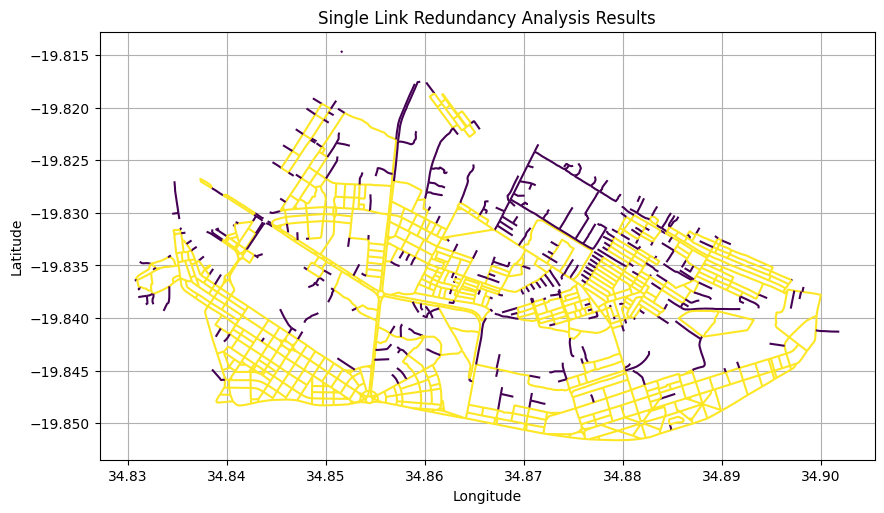

In [7]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))
redundancy_gdf.plot(column='detour', ax=ax, legend=False, cmap='viridis')
plt.title('Single Link Redundancy Analysis Results')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

![Criticality results: detour attribute](/_resources/figures/criticality_detour.png)

### Alternative route distance

We can now check the lengths of the alternative distance for each link in the network with the attribute `alt_dist`. The alternative distance refers to the length of the detour for when the link itself is not available.

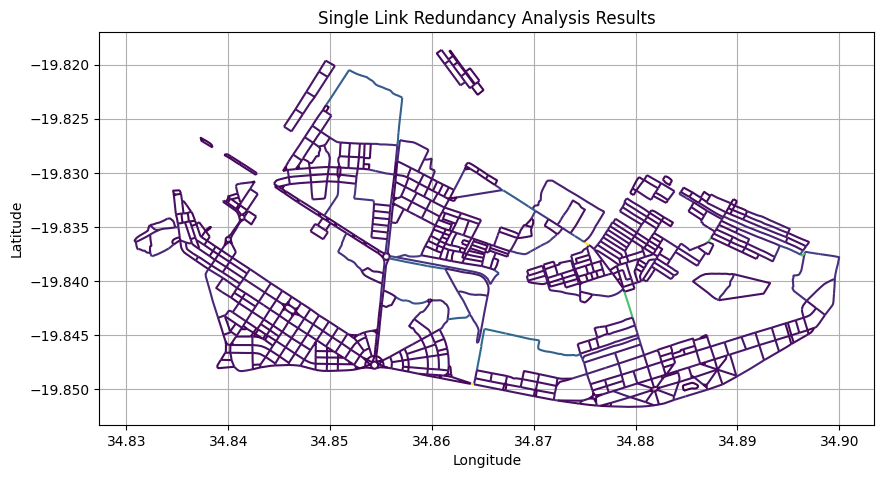

In [8]:
fig, ax = plt.subplots(figsize=(10, 10))
redundancy_gdf.plot(column='alt_length', ax=ax, legend=False, cmap='viridis')
plt.title('Single Link Redundancy Analysis Results')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

![Criticality results: alternative distance in meters.](/_resources/figures/criticality_alt_length.png)

It should be noted that there are cases where the original distance can be longer than the alternative distance. In the example below, from A (818) to B (828) the alternative distance between nodes 818 and 828 (road 1621) is shorter than the length of road nr. 1622. Therefore, the `diff_dist` attribute contains a negative value. The original link is longer than the alternative route! This is purely relevant from a network inspection point of view. In reality, most people will take road 1621 to get from A to B (if that road segment is available).

![Negative distance case](/_resources/criticality_neg.png)